In [1]:
import sys
import os


# Add the path to the parent module
sys.path.append(os.path.abspath('../..'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import deeppy as dp
import time
from tqdm import trange
import torch
import torch.optim as optim
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import numpy as np
import matplotlib.pyplot as plt




from deeppy import IngpData, LearnFrame, DatasetLoader
from deeppy.models.cv import Sane
import glob



In [3]:


data_config = {
    'hash_encoding': {
        'num_levels': 16,
        'level_dim': 2,
        'input_dim': 3,
        'log2_hashmap_size': 19,
        'base_resolution': 16
    },
    'mlp': {
        'num_layers': 3,  # Number of layers in geometric MLP
        'hidden_dim': 64,  # Hidden dimension size
    }
}

window_size = 512 + 54
batch_size = 16
input_dim = 256

dataset_config = {
    "data_path": "../../data/",
    "config": data_config,
    "window_size": window_size,
    "token_size": input_dim,
}


dataloader_args = {
    "num_workers" : 24,
    "prefetch_factor" : None,
    "shuffle" : True,
    "pin_memory" : True,
    "persistent_workers" : True,
}

data = DatasetLoader(IngpData(**dataset_config), batch_size = batch_size, 
                      splits = [0.9, 0.1, 0], dataloader_args=dataloader_args)
print(data.data.max_positions)

tensor([54])


In [4]:

embed_dim = 256*4
latent_dim = 256
num_heads = 16
num_layers = 8
window_size = window_size
max_positions = data.data.max_positions
dropout = 0.1
bias = False
projection_dim = 64

lr = 3e-4


total_epocs = 20

In [5]:
n_object = len(data.data.all_objects)
n_param = 7000000
t_param = n_object * n_param

pass_param = (window_size - 50) * (input_dim / 2) * batch_size



epochs = int(t_param/pass_param) * total_epocs
epochs

267740

In [6]:
scheduler_config = {
   
}



Scheduler_params = {
                "scheduler" : optim.lr_scheduler.OneCycleLR,
                "auto_step":True,
                 "max_lr": lr,
                "total_steps": epochs,
                "pct_start": 0.3,
                "anneal_strategy": "cos",
                "cycle_momentum": True,
                "base_momentum": 0.85,
                "max_momentum": 0.95,
                "div_factor": 25.0,
                "final_div_factor": 10000.0,
                "three_phase": True,
                "last_epoch": -1,
                "verbose": False,
}

Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr":lr,  "weight_decay" : 1e-5, "fused" : True},
    "clipper":nn.utils.clip_grad_norm_,
    "clipper_params":{"max_norm" : 5.0},
    "scheduler_params":Scheduler_params,
}

Sane_params = {
    "optimizer_params":Optimizer_params,
    "max_positions" : max_positions,
    "input_dim":input_dim,
    "latent_dim":latent_dim,
    "projection_dim" : projection_dim,
    "embed_dim":embed_dim,
    "num_heads":num_heads,
    "num_layers":num_layers,
    "context_size":window_size,
    "dropout":dropout,
    "bias" : bias,
    "device":device,
    "gamma" : [0.05,0.45],
    "ntx_temp" : 0.1,
    "torch_compile" : True,
    "amp":True,

}


model = dp.cv.Sane(**Sane_params)

# Create A LearnFrame

In [7]:
lf = LearnFrame(model,data)


# Train a Batch

- 

In [8]:
path = "checkpoints/r-sane/exp1"
os.mkdir(path)

FileExistsError: [Errno 17] File exists: 'checkpoints/r-sane/exp1'

Axes(0.125,0.53;0.775x0.35)


<Figure size 640x480 with 0 Axes>

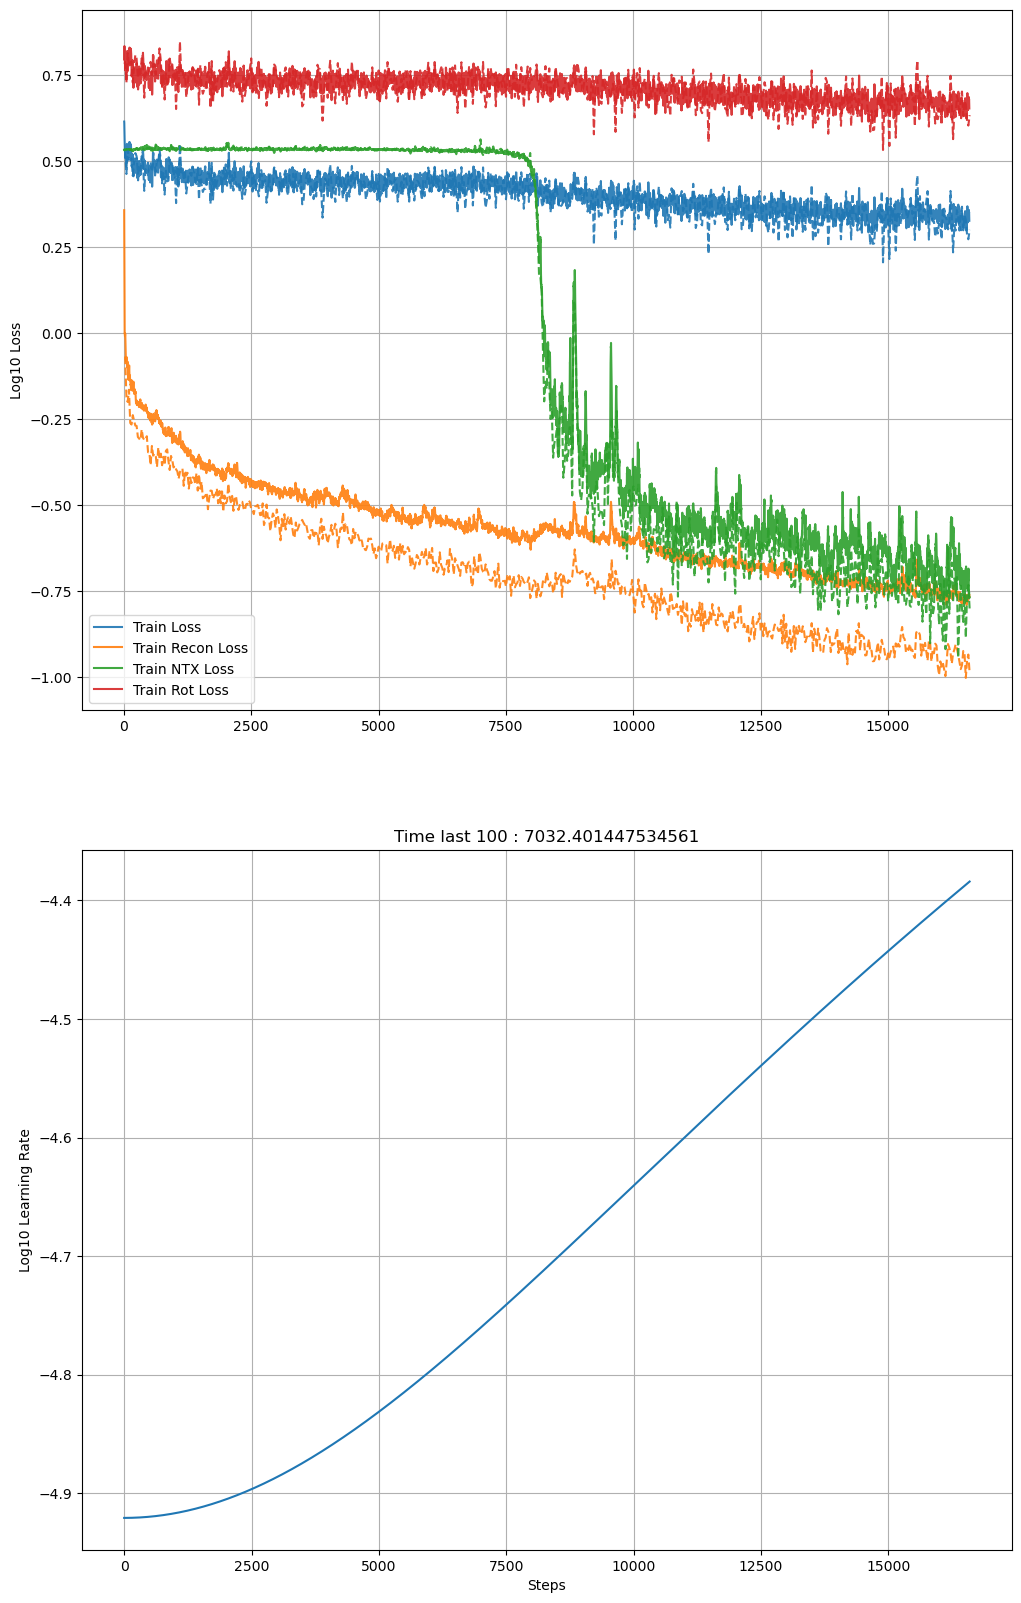

<Figure size 640x480 with 0 Axes>

In [ ]:
path = "checkpoints/r-sane/exp1"

st = time.time()
for i in range(lf.optim_epoch,epochs):

    lf.optimize()

    if (i+1)%25 == 0:
        lf.test(steps=2)

    if (i+1)%100 == 0:
        title = f"Time last 100 : {time.time()-st}"
        lf.plot(show_result = False, log = True, show_lrs= True, text = title)

    if (i+1) % 5000 == 0:
        dire = path + f"{(i+1)}"
        
        try:
            os.mkdir(dire)
        except:
            pass
        lf.save(dire)


lf.plot(show_result = True, log = True, show_lrs= True)

In [ ]:
dire = path + "final"
try:
    os.mkdir(dire)
except:
    pass
lf.save(dire)